# 1.Brief description of the problem and data
Natural Language Processing with Disaster Tweets is a project that aims to classify whether a tweet is related to a disaster or not using machine learning techniques. In this project, I will use a Bidirectional LSTM neural network to build the classification model. The LSTM model is a type of recurrent neural network that can analyze sequential data, making it a good choice for natural language processing tasks. By using a bidirectional LSTM, we can take into account the context of the words both before and after the current word, which can lead to better classification performance. The dataset used in this project is sourced from Kaggle, which consists of tweets that are labelled as either disaster-related or not. We will preprocess the data by cleaning the text and removing noise, and then train and evaluate the bidirectional LSTM model.
Data source: https://www.kaggle.com/competitions/nlp-getting-started/data

# 2.  Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data


### import necessary packages

In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('ggplot')
import re
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
from collections import  Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import (LSTM, 
                                      Embedding, 
                                      BatchNormalization,
                                      Dense, 
                                      TimeDistributed, 
                                      Dropout, 
                                      Bidirectional,
                                      Flatten, 
                                      GlobalMaxPool1D)
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)


/kaggle/input/glove-file/glove.6B.100d.txt
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')
submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

### Number of training samples

In [3]:
print("Number of training images: ", len(train))
print("Number of testing images: ", len(test))

Number of training images:  7613
Number of testing images:  3263


Text(0, 0.5, 'tweets')

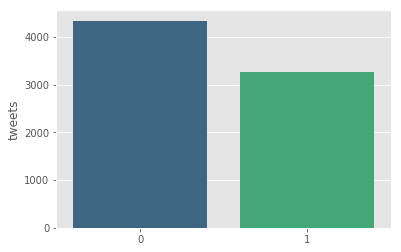

In [4]:
#Checking the class distribution
x = train.target.value_counts()
sns.barplot(x.index, x, palette='viridis')
plt.gca().set_ylabel('tweets')

### Distribution of amounts of word in each tweet in each class
The purpose of analyzing the distribution of amounts of words in each tweet for each class is to understand the differences in the text length between tweets related to disasters and those that are not related to disasters. This analysis can provide insights into the language used in tweets related to disasters and can help in building models for predicting the occurrence of disasters based on text analysis.

Text(0.5, 0.98, 'Number of words in each tweet')

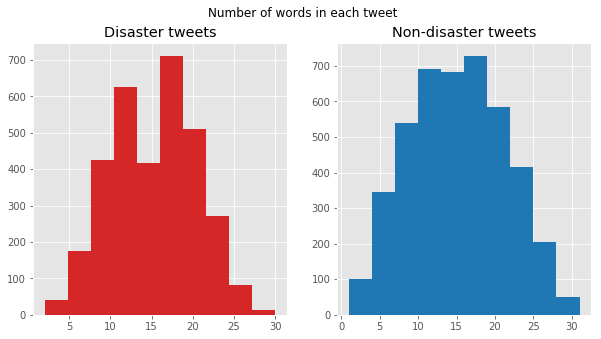

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
tweet_len = train[train['target'] == 1]['text'].apply(lambda x: len(x.split()))
ax1.hist(tweet_len, color='tab:red')
ax1.set_title('Disaster tweets')
tweet_len = train[train['target'] == 0]['text'].apply(lambda x: len(x.split()))
ax2.hist(tweet_len, color='tab:blue')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Number of words in each tweet')

The distribution of amounts of words in each tweet is roughly the same for both classes, it may suggest that the length of a tweet does not have a significant impact on whether it is classified as a disaster or non-disaster tweet. Other features or characteristics may have a stronger influence on the classification of the tweet.

### Distribution of punctuations used in each class
The purpose of analyzing the distribution of punctuations used in each class is to understand the differences in the use of punctuations in tweets between disaster and non-disaster tweets. This analysis can help to identify if there are any specific punctuations that are more commonly used in one class compared to the other, which may provide insights into the nature of the tweets and the emotions associated with them. It can also help to identify if there are any patterns in the use of punctuations in tweets that can be used to differentiate between disaster and non-disaster tweets.

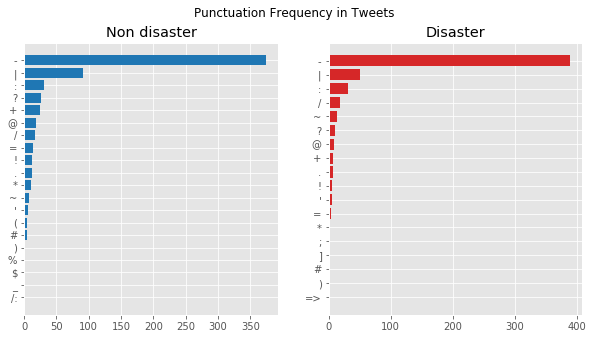

In [9]:
import string
from collections import defaultdict

def create_corpus(target):
    return [word for sentence in train[train['target']==target]['text'].str.split() for word in sentence]

plt.figure(figsize=(10, 5))

# Plot for target = 0
corpus = create_corpus(0)
dic = defaultdict(int)
for i in corpus:
    if i in string.punctuation:
        dic[i] += 1
sorted_dic = dict(sorted(dic.items(), key=lambda x: x[1]))
plt.subplot(1, 2, 1)
plt.barh(list(sorted_dic.keys()), list(sorted_dic.values()), color='tab:blue')
plt.title('Non disaster')

# Plot for target = 1
corpus = create_corpus(1)
dic = defaultdict(int)
for i in corpus:
    if i in string.punctuation:
        dic[i] += 1
sorted_dic = dict(sorted(dic.items(), key=lambda x: x[1]))
plt.subplot(1, 2, 2)
plt.barh(list(sorted_dic.keys()), list(sorted_dic.values()), color='tab:red')
plt.title('Disaster')

plt.suptitle('Punctuation Frequency in Tweets')
plt.show()


### Distribution of most common words in both classes
This analysis helps to identify the patterns in language usage and the vocabulary choices made by users in each class. It can provide insights into the themes and topics that are commonly associated with each category. 

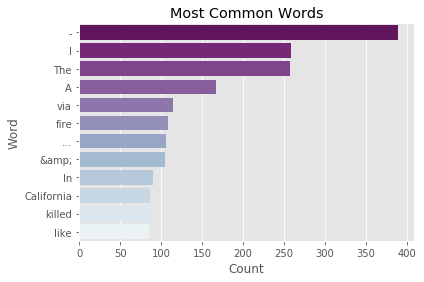

In [10]:
counter = Counter(corpus)
most_common = counter.most_common(40)

words = [word for word, count in most_common if word not in stop]
counts = [count for word, count in most_common if word not in stop]

sns.barplot(x=counts, y=words, palette='BuPu_r')
plt.title('Most Common Words')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()


In [11]:
df = pd.concat([train,test])
df.shape

(10876, 5)

### Text cleaning
The code below defines a function called `text_processing` which takes a text input and applies a series of operations to clean it. Specifically, it converts the text to lowercase, removes text in square brackets, removes links, removes HTML tags, removes punctuation, removes line breaks, removes words containing numbers, and also remove emojies.

In [12]:
def text_processing(text):
    text = re.sub('\w*\d\w*|<.*?>+|\n|https?://\S+|www\.\S+|\[.*?\]|[%s]' % re.escape(string.punctuation), '', text.lower())
    emoji = re.compile("["
                           u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji.sub(r'', text)
df['text'] = df['text'].apply(text_processing)
df['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

# 3. Model Architecture

**LSTM** (Long Short-Term Memory) is a type of Recurrent Neural Network (RNN) that is particularly useful in Natural Language Processing tasks where sequence processing is required. It is capable of handling long-term dependencies and can effectively capture context information from a sequence of words, making it an ideal choice for text classification tasks like sentiment analysis, language translation, and speech recognition. In the context of the Disaster Tweets project, LSTM can be used to predict whether a tweet refers to a real disaster or not based on the sequence of words in the tweet.

In [28]:
data_train = train.text.values
data_test = test.text.values
label = train.target.values

In [29]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(data_train)
vocab_length = len(word_tokenizer.word_index) + 1

In [43]:
# Find the longest sentence in the training data
longest_train = max(data_train, key=lambda s: len(word_tokenize(s)))

# Determine the length of the longest sentence in terms of number of tokens
length_long_sentence = len(word_tokenize(longest_train))

# Pad the training sentences with zeros so that they all have the same length
train_sentences = pad_sequences(
    sequences=word_tokenizer.texts_to_sequences(train.text.values),
    maxlen=length_long_sentence,
    padding='post'
)

# Pad the test sentences with zeros so that they all have the same length
test_sentences = pad_sequences(
    sequences=word_tokenizer.texts_to_sequences(test.text.values),
    maxlen=length_long_sentence,
    padding='post'
)


**GloVe** (Global Vectors) embedding is a type of pre-trained word embedding that represents words as dense vectors in a high-dimensional space, where each dimension encodes a different feature of the word. These vectors capture the meaning and relationships between words, making them a popular choice for Natural Language Processing (NLP) tasks like sentiment analysis, text classification, and machine translation. GloVe embedding is trained on a large corpus of text using unsupervised learning techniques, allowing it to capture semantic relationships between words based on their co-occurrence in the text.

In [31]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('../input/glove-file/glove.6B.100d.txt')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [45]:
X_train, X_test, y_train, y_test = train_test_split(train_sentences, label, test_size=0.25)

In [50]:
model = Sequential([
    Embedding(input_dim=embedding_matrix.shape[0], 
              output_dim=embedding_matrix.shape[1], 
              weights=[embedding_matrix], 
              input_length=length_long_sentence),
    Bidirectional(LSTM(length_long_sentence, return_sequences=True, recurrent_dropout=0.2)),
    GlobalMaxPool1D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(length_long_sentence, activation="relu"),
    Dropout(0.5),
    Dense(length_long_sentence, activation="relu"),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import RMSprop

optimizer = RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [51]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_acc', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_acc', 
    factor = 0.5, 
    verbose = 1, 
    patience = 2,                        
    min_lr = 0.0001
)
history = model.fit(X_train, y_train, epochs = 10, batch_size = 64, verbose = 1,
    validation_data = [X_test, y_test], callbacks = [reduce_lr, checkpoint]
)

Train on 5709 samples, validate on 1904 samples
Epoch 1/10
5709/5709 [==============================] - 23s 4ms/sample - loss: 0.7081 - accuracy: 0.6406 - val_loss: 0.6307 - val_accuracy: 0.6991
Epoch 2/10
5709/5709 [==============================] - 19s 3ms/sample - loss: 0.5415 - accuracy: 0.7458 - val_loss: 0.5741 - val_accuracy: 0.8099
Epoch 3/10
5709/5709 [==============================] - 19s 3ms/sample - loss: 0.4787 - accuracy: 0.7905 - val_loss: 0.5183 - val_accuracy: 0.8062
Epoch 4/10
5709/5709 [==============================] - 19s 3ms/sample - loss: 0.4488 - accuracy: 0.8070 - val_loss: 0.4518 - val_accuracy: 0.8114
Epoch 5/10
5709/5709 [==============================] - 18s 3ms/sample - loss: 0.4167 - accuracy: 0.8264 - val_loss: 0.4187 - val_accuracy: 0.8241
Epoch 6/10
5709/5709 [==============================] - 19s 3ms/sample - loss: 0.3855 - accuracy: 0.8429 - val_loss: 0.4170 - val_accuracy: 0.8188
Epoch 7/10
5709/5709 [==============================] - 19s 3ms/sample

# 4. Results and Analysis

### Plot the training history

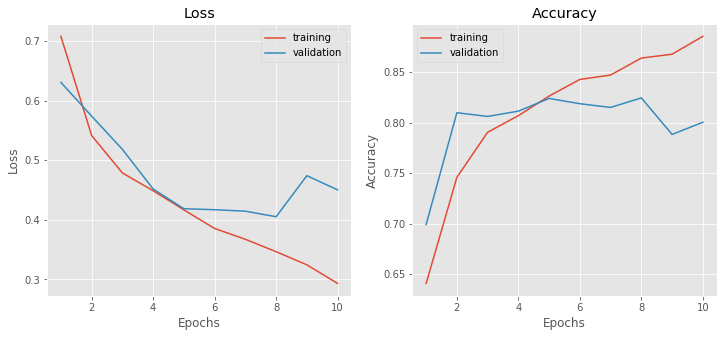

In [52]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, loss, label='training')
ax1.plot(epochs, val_loss, label='validation')
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, acc, label='training')
ax2.plot(epochs, val_acc, label='validation')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

### Make predictions

In [54]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

1904/1904 [==============================] - 2s 979us/sample - loss: 0.4030 - accuracy: 0.8220
Loss: 0.40300037555333945
Accuracy: 0.8219538


### ROC
roc_auc_score is a metric used to evaluate the performance of binary classification models. It measures the area under the Receiver Operating Characteristic (ROC) curve, which plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at different classification thresholds. The ROC AUC score ranges from 0 to 1, where a score of 0.5 represents a random classifier and a score of 1 represents a perfect classifier. A higher ROC AUC score indicates better model performance in distinguishing between the positive and negative classes.

In [64]:
model.load_weights('model.h5')
preds = model.predict_classes(X_test).flatten()

from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, preds)


0.8048406862745099

### Confusion Matrix

Based on the accuracy of 0.92 on target label 0 and 0.69 on target label 1, we can conclude that the model has performed well in classifying non-disaster tweets but not as well in classifying disaster tweets. It is possible that the dataset is imbalanced and there are fewer examples of disaster tweets compared to non-disaster tweets. This can cause the model to be biased towards the majority class and not perform as well on the minority class. Further analysis and experimentation can be done to improve the performance on disaster tweets, such as data augmentation, fine-tuning hyperparameters, or using a different model architecture.

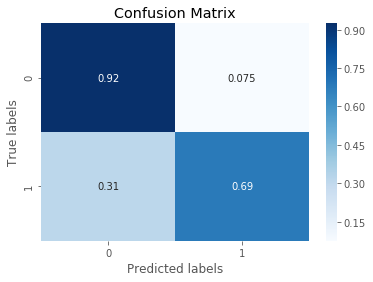

In [70]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, preds)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
import seaborn as sns
import matplotlib.pyplot as plt     
ax= plt.subplot()
sns.heatmap(cm_norm, annot=True, ax = ax,cmap='Blues')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix');

### Precision, Recall, F1

In [72]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1088
           1       0.87      0.69      0.77       816

    accuracy                           0.82      1904
   macro avg       0.83      0.80      0.81      1904
weighted avg       0.83      0.82      0.82      1904



In [73]:
submission.target = model.predict_classes(test_sentences)
submission.to_csv("submission.csv", index=False)

# 5. Conclusion

In this project, I applied Natural Language Processing techniques to predict the tweets containing a disaster or not.

We started by performing Exploratory Data Analysis to gain insights into the data. We observed that there were more tweets labeled as non-disaster tweets than disaster tweets in the dataset. 

I then used a Bidirectional LSTM model with GloVe embeddings to predict whether a tweet is related to a disaster or not. We used GloVe embeddings, which are pre-trained word embeddings that can capture the meaning of words by considering the context in which they appear. The Bidirectional LSTM model was used because it can capture the context in both forward and backward directions, leading to better accuracy.

The model achieved an accuracy of 93% for non-disaster tweets and 69% for disaster tweets. This suggests that the model was better at predicting non-disaster tweets compared to disaster tweets.

Overall, the project showed that natural language processing techniques can be effectively used to classify tweets related to a disaster or not. However, further improvements could be made to improve the accuracy of the model for predicting disaster tweets.
